# 인디음악 가사 감성 분석 



# 패키지 설치 

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 45.2 MB/s 


In [2]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-07-01 05:34:38--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-07-01 05:34:38--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc87248eb246f43ac79083e47369.dl.dropboxusercontent.com/cd/0/get/BoPhj0blE9QVAS4NJsTmQX5vySbcSIB4BID_WmCmtdTn-KFw6eJbMUnB3B7_AARNX_UGy0Apo1e8ZJhEEqKtUHGN5c50kYsEr5O5gQ-cLCZP7srB-iJiv4ZnFaK34EsdTZcSVEeTkA1e72OFSwzTAZrKuAFfKVTYlJJmAaMMK6dlSLgLgWMpaWxTw2SFJ9P6s6M/file?dl=1# [following]
--2022-07-01 05:34:39--  https://uc87248eb246f43ac79083e47369.dl.dropboxusercontent.com/cd/0/g

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (4,302 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# 데이터 전처리

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm import tqdm
from konlpy.tag import Okt
from konlpy.tag import Mecab
from gensim.models import Word2Vec
from gensim import corpora 
from gensim import models

from wordcloud import WordCloud
from collections import Counter


장르별로 크롤링을 해왔으므로 데이터를 하나로 합쳐준다. 

특수문자 제거, 문장 나누기를 해주고 가사 전부 영어인 노래는 삭제한다. 

In [5]:
df1 = pd.read_excel("/content/drive/MyDrive/lyric/data/502.xlsx", index_col=0)
df2 = pd.read_excel("/content/drive/MyDrive/lyric/data/503.xlsx", index_col=0)
df3 = pd.read_excel("/content/drive/MyDrive/lyric/data/504.xlsx", index_col=0)

df1['genre'] = "acoustic"
df2['genre'] = "rock"
df3['genre'] = "electronic"


df = pd.concat([df1, df2, df3])
df = df.dropna() # 가사 결측치 제거 
df = df.reset_index(drop=True) # 인덱스 리셋

df.shape 

(1470, 4)

In [6]:
# 소문자 변경, 특수문자 제거, 문장 나누기 
df['lyric_split'] = df['lyric'].str.lower()
df['lyric_split'] = df['lyric_split'].str.replace(pat=r'[^가-힣a-z\n]', repl= r' ', regex=True)
df['lyric_split'] = df['lyric_split'].apply(lambda x: x.split('\n'))

In [ ]:

# 영어가사 제거 
def eng_remove(df):
    alpha_idx = []
    for idx, doc in enumerate(df):
        alpha = []
        for sentence in doc:
            if sentence.replace(' ', '').encode().isalpha(): # 문장이 영어일때만 
                alpha.append(1)
            else: 
                alpha.append(0)
        if len(alpha) == alpha.count(1):
            alpha_idx.append(idx)
    df = df.drop(alpha_idx)
    df = df.reset_index(drop=True)
    return df
    

In [ ]:
df = eng_remove(df)
df.shape

(1466, 5)

## 형태소 분석& 불용어 제거 

word2vec 학습에 앞서 가사를 형태소 단위로 분리하고 불용어를 제거해줘야 한다. 

불용어 제거에는 검증되고 통일된 방식이 없고 보통 빈도수를 체크하거나 조사/접사 등 중요하지 않은 단어들을 삭제하는 방식을 따른다. 

하단 논문에 보면 텍스트의 의미를 구성하는데 중요한 역할을 하지 않는 품사 태그를 목록을 제공한다. 

이 목록을 이용해 일차적으로 제거를 하고 다시 목록을 체크하면서 중요하지 않은 것들을 불용어로 처리하려 한다. 

[reference 텍스트마이닝을 위한 한국어 불용어 목록 연구](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002390885)

In [7]:

def listToString(str_list):
    result = ""
    for s in str_list:
        result += s + " "
    return result.strip()

df['lyric_str'] = df['lyric_split'].apply(listToString)

In [8]:
# 품사 태깅
mecab = Mecab()

tokenized = []
for sentence in tqdm(df['lyric_str']):

    tokenized.append(mecab.pos(sentence))


100%|██████████| 1470/1470 [00:01<00:00, 876.28it/s] 


불용어를 설정해주기 위해 빈도수로 단어와 품사를 확인. 

해당 단어들은 학습시 큰 의미가 없는 조사/접미사/어미 들이 대부분 이었으며 나, 너같은 자주 사용하는 대명사도 순위권 안에 들어간다.  

In [9]:

# tokenized_data = [] 
# for i in range(len(tokenized)):
#     tokenized_data.append(sum(tokenized[i] , []))
tokenized_all = sum(tokenized, [])

counts = Counter(tokenized_all)
counts.most_common(20) 

[(('을', 'JKO'), 4933),
 (('고', 'EC'), 4897),
 (('는', 'ETM'), 4744),
 (('이', 'JKS'), 4381),
 (('에', 'JKB'), 4127),
 (('나', 'NP'), 4006),
 (('i', 'SL'), 4004),
 (('너', 'NP'), 3740),
 (('어', 'EC'), 3568),
 (('you', 'SL'), 3551),
 (('도', 'JX'), 3537),
 (('가', 'JKS'), 3394),
 (('의', 'JKG'), 3116),
 (('를', 'JKO'), 2962),
 (('지', 'EC'), 2626),
 (('아', 'EC'), 2531),
 (('는', 'JX'), 2387),
 (('은', 'ETM'), 2247),
 (('은', 'JX'), 2219),
 (('게', 'EC'), 2051)]

확인 한 값들을 바탕으로 불용어 제거 작업. 

한글은 논문에서 참고한 태그들과 [mecab의 품사 태그](https://docs.google.com/spreadsheets/d/1-9blXKjtjeKZqsf4NzHeYJCrr49-nXeRF6D80udfcwY/edit#gid=589544265) 값을 확인 하면서 감탄사나 의존명사들 의미 없는 단어들의 태그를 추가로 삭제 했다. 

영어는 nltk에서 제공하는 불용어 리스트와 보통 노래 할 때 멜로디를 흥얼거리는 용도로 사용되는 woo, la, yeah 같은 수식어를 포함해 제외했다. 



In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# 한글 태그 불용어 제거 
tags = ['NNG','VV','VA','MM','MAG','SL']

# 영어 따로 처리 
stopwords_en = [['oh','u','yeah','woo','la','yuh','baby','mm']] # 빈도수 체크 후 의미없는 단어 제거 
stopwords_en.append(stopwords.words('english')) # nltk에서 제공하는 불용어 리스트 추가 
stopwords_en = sum(stopwords_en , [])

# stopword_kor = ['난','날','널','넌','내','네','다','더','이','게','야','겠','했','걸','줘','그','었','엔','았','또','키키','랄라','렐라','샤랄','랄라','빠','빠빠','로로','롤','롤로','휘','휘휘','우','우우우','우우']

tokenized_data = []
for sentence in tqdm(df['lyric_str']):
    tokenized_sentence = mecab.pos(sentence)
    stoptag_removed = [n for n, tag in tokenized_sentence if tag in tags]
    # stopword_kor_removed = [w for w in stoptag_removed if not w in stopword_kor]
    stopword_en_removed = [w for w in stoptag_removed if not w in stopwords_en and len(w) > 1]
    tokenized_data.append(stopword_en_removed)

100%|██████████| 1470/1470 [00:03<00:00, 476.73it/s]


총 단어 개수 : 330150
가사의 최대 길이 : 881
가사의 평균 길이 : 224.59183673469389


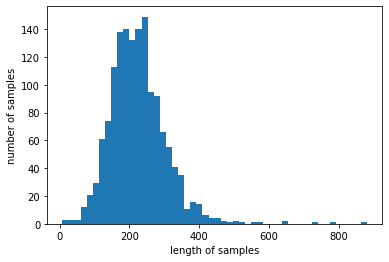

In [12]:
# 불용어 제거 전의 가사 길이 분포도 
print('총 단어 개수 :', len(sum(tokenized , [])))
print('가사의 최대 길이 :',max(len(lyric) for lyric in tokenized))
print('가사의 평균 길이 :',sum(map(len, tokenized))/len(tokenized))
plt.hist([len(lyric) for lyric in tokenized], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

총 단어 개수 : 84490
가사의 최대 길이 : 373
가사의 평균 길이 : 57.476190476190474


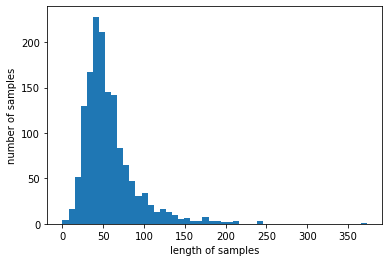

In [13]:
# 불용어 제거 후의 가사 길이 분포도 약 19만개의 단어가 줄었다. 
print('총 단어 개수 :', len(sum(tokenized_data , [])))
print('가사의 최대 길이 :',max(len(lyric) for lyric in tokenized_data))
print('가사의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(lyric) for lyric in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

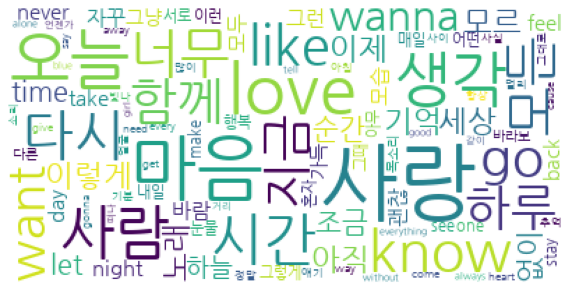

In [14]:

tokenized_all = sum(tokenized_data , [])

counts = Counter(tokenized_all)
tags = counts.most_common(100) 

FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

wc = WordCloud(font_path=FONT_PATH,background_color="white", max_font_size=60).generate_from_frequencies(dict(tags))
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(wc)
plt.show()

# Word2vec

감성을 분류하기 위해 인디음악 가사의 특징을 알아보았다. 

대중음악은 주류를 따라가는 상업적인 음악인 반면, 인디음악은 보다 음악적 진정성과 예술적 본질을 지키려는 특성이 있고 이런 특징이 가사에서도 나타난다. 특징을 참고해 범주를 나눈다면, 사랑 관련, 일상 관련, 자아성찰/위로/힐링 관련, 사회비판적 메세지 정도로 범주를 나눌 수 있다. 


그중에서도 사랑 관련된 노래가 압도적으로 많기 때문에 사랑과 비슷한 단어를 검색 할 경우 온갖 단어들이 다 비슷하다고 나와서 정확도가 매우 떨어지는 문제가 있다.

In [15]:
model = Word2Vec(sentences = tokenized_data, size = 150, window = 5, min_count = 1, workers = 4, sg = 1)


In [20]:
emotion = ['사랑','행복','이별','추억','슬픔','우울','새벽','감미','노을','여름','가을','love','night']
emotion_list = []
for e in emotion:
    emotion_one = []
    for word in model.wv.most_similar(e, topn=20):
        emotion_one.append(word[0])
    emotion_list.append(emotion_one)


In [21]:
idx = 0
freq = []
for idx in range(len(tokenized_data)):
    f = []
    for k in range(len(emotion)): 
        for i in emotion_list[k]:
            if i in tokenized_data[idx]:
                f.append(k)
    freq.append(f)


In [22]:

max_list = []
for i in freq:
    if not i:
        max_list.append(100) # 단어사전에 없는 노래 
    else:
        max_list.append(max(Counter(i)))
Counter(max_list)

Counter({0: 44,
         1: 33,
         2: 42,
         3: 47,
         4: 23,
         5: 69,
         6: 75,
         7: 11,
         8: 49,
         9: 472,
         10: 172,
         11: 196,
         12: 119,
         100: 118})

# 토픽 모델링 

In [ ]:
# 사전 구축 
dictionary = corpora.Dictionary(tokenized_data)  
corpus = [dictionary.doc2bow(text) for text in tokenized_data] 


In [ ]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
        num_topics=30, random_state = 1)                   # 모델구축

for t in lda.show_topics():  # 주제마다 출현 확률이 높은 단어 순으로 출력
	  print(t)


(29, '0.019*"alone" + 0.019*"오늘" + 0.017*"사랑" + 0.013*"hey" + 0.012*"love" + 0.010*"함께" + 0.009*"다시" + 0.008*"waiting" + 0.008*"노래" + 0.008*"wake"')
(21, '0.033*"step" + 0.012*"one" + 0.012*"two" + 0.012*"지금" + 0.011*"함께" + 0.011*"시간" + 0.011*"사랑" + 0.011*"조금" + 0.010*"너무" + 0.010*"three"')
(18, '0.011*"사랑" + 0.011*"너무" + 0.009*"생각" + 0.009*"가득" + 0.009*"오늘" + 0.008*"시간" + 0.008*"love" + 0.008*"다시" + 0.008*"매일" + 0.007*"뮤직"')
(1, '0.016*"오늘" + 0.015*"마음" + 0.013*"다시" + 0.013*"필요" + 0.012*"서로" + 0.009*"know" + 0.009*"시간" + 0.008*"사랑" + 0.007*"feel" + 0.007*"기억"')
(5, '0.011*"마음" + 0.011*"기억" + 0.011*"backspace" + 0.011*"사랑" + 0.010*"함께" + 0.010*"자꾸" + 0.010*"다시" + 0.010*"초콜릿" + 0.009*"everything" + 0.009*"지금"')
(25, '0.018*"마음" + 0.018*"like" + 0.017*"사랑" + 0.015*"사람" + 0.013*"모르" + 0.012*"하루" + 0.011*"하늘" + 0.009*"지금" + 0.009*"세상" + 0.008*"함께"')
(22, '0.036*"나나" + 0.014*"없이" + 0.012*"오늘" + 0.011*"parts" + 0.011*"wanna" + 0.010*"잠깐" + 0.010*"모두" + 0.009*"하루" + 0.008*"마음" + 0.007*"night"

In [ ]:
for i, topic in enumerate(lda[corpus]):
    print(i, '비율', topic)

0 비율 [(4, 0.4532605), (24, 0.53855234)]
1 비율 [(11, 0.9896057)]
2 비율 [(28, 0.98209876)]
3 비율 [(16, 0.9810457)]
4 비율 [(16, 0.9836158)]
5 비율 [(17, 0.37643406), (20, 0.61060303)]
6 비율 [(14, 0.98913854)]
7 비율 [(16, 0.98728067)]
8 비율 [(10, 0.22243643), (18, 0.74839693)]
9 비율 [(0, 0.9853535)]
10 비율 [(19, 0.97387385)]
11 비율 [(11, 0.9802721)]
12 비율 [(10, 0.986758)]
13 비율 [(8, 0.98888886)]
14 비율 [(24, 0.97698414)]
15 비율 [(16, 0.9688172)]
16 비율 [(4, 0.9789855)]
17 비율 [(13, 0.9902357)]
18 비율 [(22, 0.9798611)]
19 비율 [(17, 0.98333335)]
20 비율 [(20, 0.9785185)]
21 비율 [(10, 0.9758333)]
22 비율 [(8, 0.2368404), (16, 0.65149677), (24, 0.09435515)]
23 비율 [(8, 0.059019834), (19, 0.16881773), (21, 0.11453709), (23, 0.6364872)]
24 비율 [(0, 0.9897163)]
25 비율 [(9, 0.9851282)]
26 비율 [(18, 0.8897944), (24, 0.09323591)]
27 비율 [(15, 0.97521365)]
28 비율 [(4, 0.18744886), (14, 0.35550213), (25, 0.4374838)]
29 비율 [(24, 0.0728756), (28, 0.9148437)]
30 비율 [(4, 0.38647553), (6, 0.36343625), (22, 0.22361758)]
31 비율 [(3, 0.06

In [ ]:
from gensim.models import CoherenceModel
coherence = CoherenceModel(model=lda, texts=tokenized_data, dictionary=dictionary,coherence='c_v')
ldamallet = coherence.get_coherence()
ldamallet

0.3489707147803307

In [ ]:
for t in range(lda.num_topics):
    if t== 47:
        print(lda.show_topic(t,30))

[('go', 0.029704299), ('사랑', 0.0200334), ('let', 0.015542173), ('know', 0.011883388), ('모든', 0.011145914), ('다시', 0.009747835), ('stay', 0.009214767), ('love', 0.0077676214), ('마음', 0.0071079494), ('이제', 0.007037808), ('one', 0.006844046), ('easy', 0.0066920035), ('세상', 0.006501151), ('without', 0.0063585876), ('want', 0.0059524844), ('please', 0.00590141), ('day', 0.005438974), ('눈물', 0.0054160766), ('자꾸', 0.005373253), ('함께', 0.0053439336), ('이렇게', 0.0052265273), ('never', 0.005223438), ('feel', 0.005023195), ('지금', 0.0049663866), ('like', 0.0049618534), ('생각', 0.0048775175), ('모습', 0.0047035925), ('오늘', 0.0045351265), ('say', 0.0045236945), ('wanna', 0.004452317)]


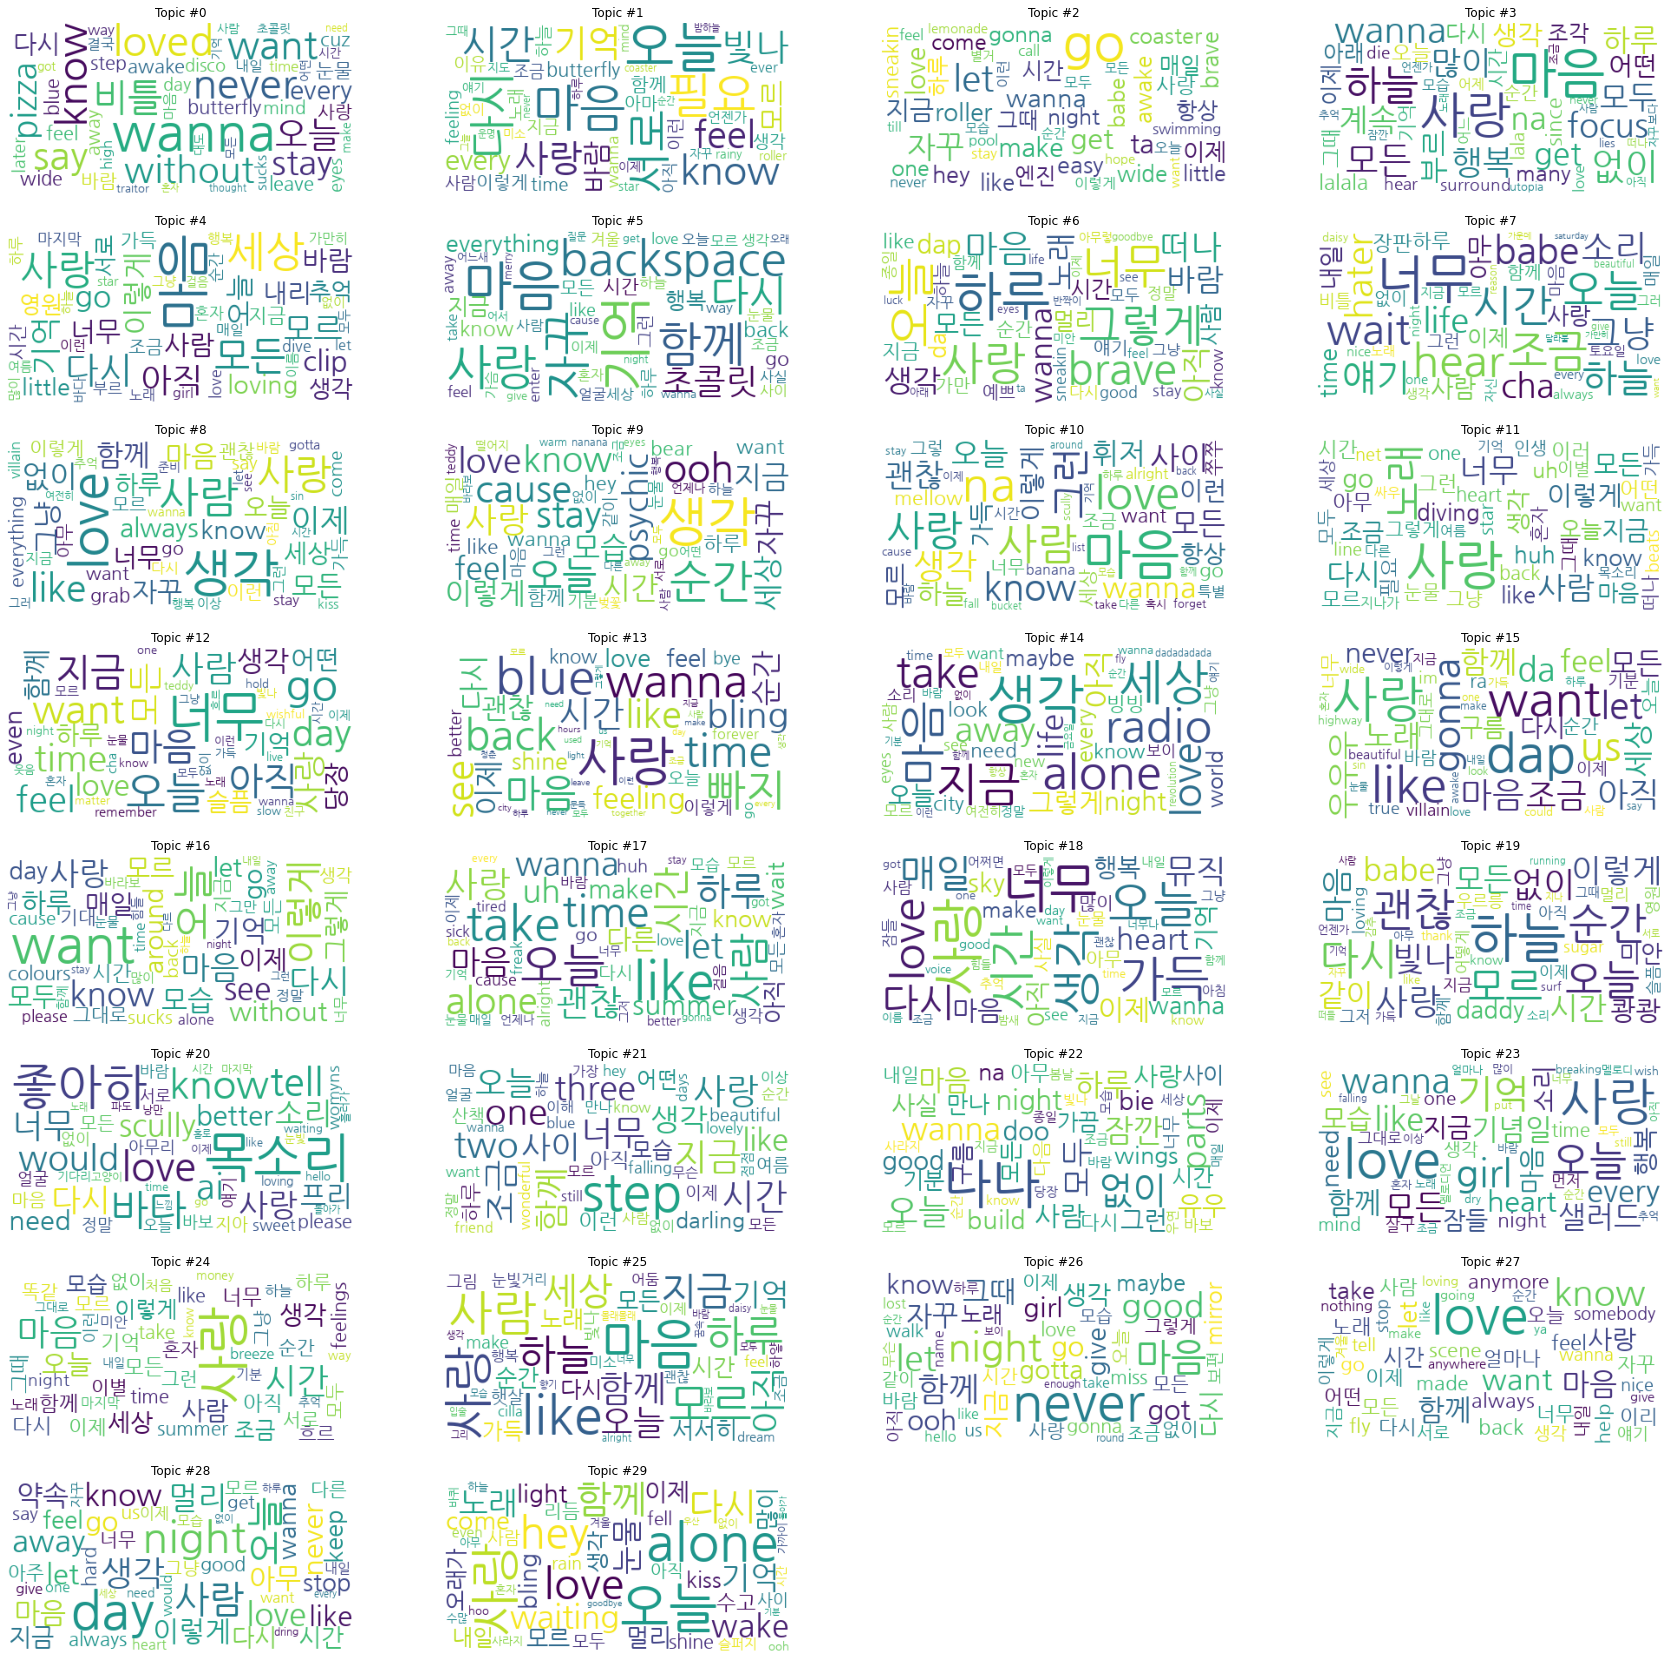

In [ ]:
plt.figure(figsize=(30,30))
for t in range(lda.num_topics):
    plt.subplot(8,4,t+1)
    x = dict(lda.show_topic(t,50))
    im = wc.generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))

# plt.savefig('LDA_wordcloud.png', bbox_inches='tight')    